# Using FastAI ULMFiT for Text Classification with Transfer Learning


## 0. Setup

In [1]:
from fastai.text import *
import pandas as pd
import numpy as np

pd.set_option('display.max_colwidth', -1)

from google.colab import drive
drive.mount('/content/gdrive')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  """


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


## 1. Import the data

In [2]:
# Loaded dataset and lables after creating the folder structure as shown below in Google
text_path = 'gdrive/My Drive/EAI 6010 Assignments Data Set/Class 3 - ULMfit/title_StackOverflow.txt'
label_path = 'gdrive/My Drive/EAI 6010 Assignments Data Set/Class 3 - ULMfit/label_StackOverflow.txt'

df_text = pd.read_csv(text_path, sep='\t', names=['text'], header=None)
df_label = pd.read_csv(label_path, sep='\t', names=['label'], header=None)

df = pd.concat([df_label, df_text], axis=1, sort=False)
print('Length of dataset: '+str(len(df.index)))
df.head()

Length of dataset: 20000


,label,text
0,18,How do I fill a DataSet or a DataTable from a LINQ query resultset ?
1,18,How do you page a collection with LINQ?
2,3,Best Subversion clients for Windows Vista (64bit)
3,3,"Best Practice: Collaborative Environment, Bin Directory, SVN"
4,7,Visual Studio Setup Project - Per User Registry Settings


In [3]:
mapping = {
  1: 'wordpress',
  2: 'oracle',
  3: 'svn',
  4: 'apache',
  5: 'excel',
  6: 'matlab',
  7: 'visual-studio',
  8: 'cocoa',
  9: 'osx',
  10: 'bash',
  11: 'spring',
  12: 'hibernate',
  13: 'scala',
  14: 'sharepoint',
  15: 'ajax',
  16: 'qt',
  17: 'drupal',
  18: 'linq',
  19: 'haskell',
  20: 'magento'
}

df['label'] = df['label'].map(mapping)

df.head()

,label,text
0,linq,How do I fill a DataSet or a DataTable from a LINQ query resultset ?
1,linq,How do you page a collection with LINQ?
2,svn,Best Subversion clients for Windows Vista (64bit)
3,svn,"Best Practice: Collaborative Environment, Bin Directory, SVN"
4,visual-studio,Visual Studio Setup Project - Per User Registry Settings


## 2. Create train & validation datasets and FastAI data bunch

In [4]:
from sklearn.model_selection import train_test_split

df_trn, df_val = train_test_split(df, stratify = df['label'], test_size = 0.3)

df_trn.shape, df_val.shape

((14000, 2), (6000, 2))

In [5]:
# Language model data - use TextLMDataBunch.from_df
data_lm = TextLMDataBunch.from_df(train_df = df_trn, valid_df = df_val, path = "")

# Classifier model data
data_clas = TextClasDataBunch.from_df(train_df = df_trn, valid_df = df_val, path = "", vocab=data_lm.train_ds.vocab, bs=32)

/usr/local/lib/python3.7/dist-packages/fastai/core.py:302: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(a, dtype=dtype, **kwargs)


/usr/local/lib/python3.7/dist-packages/fastai/text/data.py:124: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  sort_idx = np.concatenate(np.random.permutation(ck_idx[1:])) if len(ck_idx) > 1 else np.array([],dtype=np.int)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


In [6]:
# Checking the data batch
data_clas.show_batch()

/usr/local/lib/python3.7/dist-packages/fastai/text/data.py:124: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  sort_idx = np.concatenate(np.random.permutation(ck_idx[1:])) if len(ck_idx) > 1 else np.array([],dtype=np.int)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


text,target
"xxbos xxmaj why do i receive a "" xxmaj out of xxmaj windows xxmaj resources "" warning when i open numerous figure windows in xxup matlab [ 7.0 ( xxup xxunk ) and beyond ] on a xxmaj microsoft xxmaj windows xxup pc ?",matlab
xxbos xxmaj is there any way to avoid installing xxmaj microsoft xxmaj visual xxmaj studio 2008 xxmaj team xxmaj system xxmaj database xxmaj edition to be able to build xxunk projects on a xxunk build server ?,visual-studio
"xxbos xxmaj assume that wordpress is an xxunk - there xxup cms . xxmaj what xxmaj plugins would you add to the ' core ' to make it equal to "" xxmaj real "" xxunk ?",wordpress
xxbos xxmaj how the xxmaj scala script that xxunk 5 g log file from network drive should be modified in order to read last x lines ( like ' tail ' in xxmaj unix ) ?,scala
"xxbos xxmaj how to tell xxmaj apache , in reverse proxy mode , to intercept or trap 302 responses from backend server and redirect internally without sending 302 response back to client ?",apache


## 3. Create and Train the Language Model

In [7]:
# To Create a Language Model Learner
learner = language_model_learner(
    data_lm, # Data
    AWD_LSTM, # Pre-trained model which will be used
    drop_mult = 0.2, # Random drop-out the mentioned fraction of values 
    metrics = [accuracy, Perplexity( )] # Perplexity is the Cross Entropy for Language models - https://docs.fast.ai/metrics.html#Perplexity
).to_fp16( )

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


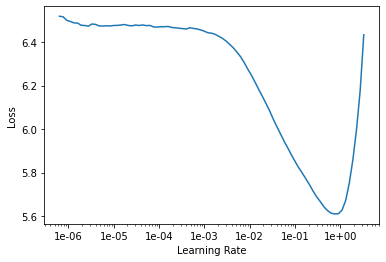

In [8]:
learner.lr_find()
learner.recorder.plot()

In [9]:
learner.fit_one_cycle(3, 1e-02)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,5.302916,4.239717,0.289614,69.388214,00:02
1,4.469075,4.010730,0.314286,55.187183,00:02
2,4.070681,3.977638,0.317608,53.390778,00:02


In [10]:
# Save this Language Model Learner
learner.save_encoder('ULMFineTuned_LanguageModel')

## 4. Using the Language Model to Train the Classifier

In [11]:
# To Create a Text Classifier Learner
learner = text_classifier_learner(
    data_clas, # Data
    AWD_LSTM, # Pre-trained model which will be used
    drop_mult = 0.4, # Random drop-out the mentioned fraction of values
    metrics = accuracy
).to_fp16( )

learner.load_encoder('ULMFineTuned_LanguageModel')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (14000 items)
x: TextList
xxbos xxmaj how to use an xxmaj internet xxmaj subversion respository when xxunk code ?,xxbos xxmaj how can i convert a ( xxunk ( xxmaj int , xxmaj int ) xxmaj word8 ) into a lazy bytestring ?,xxbos xxmaj change the default list aspx pages in sharepoint,xxbos xxmaj how to create a xxmaj visual xxmaj studio xxmaj setup xxmaj project registry value with the application install path ?,xxbos how to use scala internals to compile source faster than xxunk ( fast scala compiler )
y: CategoryList
svn,haskell,sharepoint,visual-studio,scala
Path: .;

Valid: LabelList (6000 items)
x: TextList
xxbos xxmaj automatic tracking of build number in xxup vs 2005 ?,xxbos xxmaj hibernate xxup hql : how to use a complex left join fetch,xxbos i need to order a list that is dependant on another list . how to change both lists ?,xxbos xxmaj oracle / xxup sql : xxmaj why does query " xxup select * xxup from records xxup where rownum 

epoch,train_loss,valid_loss,accuracy,time


/usr/local/lib/python3.7/dist-packages/fastai/text/data.py:124: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  sort_idx = np.concatenate(np.random.permutation(ck_idx[1:])) if len(ck_idx) > 1 else np.array([],dtype=np.int)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


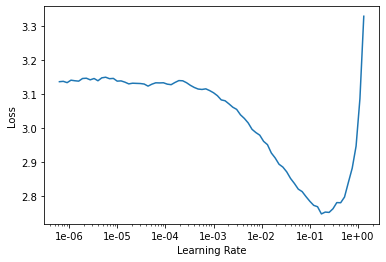

In [12]:
learner.lr_find()
learner.recorder.plot()

In [13]:
learner.fit_one_cycle(5, 1e-02)

epoch,train_loss,valid_loss,accuracy,time
0,1.956927,1.487667,0.573333,00:07
1,1.707686,1.259664,0.637833,00:05
2,1.734604,1.185818,0.674833,00:06
3,1.506300,1.073127,0.703167,00:06
4,1.494718,1.070573,0.709167,00:06


/usr/local/lib/python3.7/dist-packages/fastai/text/data.py:124: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  sort_idx = np.concatenate(np.random.permutation(ck_idx[1:])) if len(ck_idx) > 1 else np.array([],dtype=np.int)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/fastai/text/data.py:124: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must

In [14]:
learner.freeze_to(-2)
learner.fit_one_cycle(4, slice(4e-3, 1e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,1.416987,0.949328,0.740000,00:08
1,1.121821,0.714608,0.805167,00:09
2,0.876076,0.660271,0.819000,00:09
3,0.797487,0.634805,0.824000,00:09


/usr/local/lib/python3.7/dist-packages/fastai/text/data.py:124: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  sort_idx = np.concatenate(np.random.permutation(ck_idx[1:])) if len(ck_idx) > 1 else np.array([],dtype=np.int)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:1104: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non

In [15]:
learner.unfreeze()
learner.fit_one_cycle(4, slice(2e-3/100, 2e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.661308,0.587310,0.832500,00:15
1,0.606144,0.549293,0.842000,00:15
2,0.490826,0.531293,0.853500,00:14
3,0.406718,0.532170,0.851000,00:15


/usr/local/lib/python3.7/dist-packages/fastai/text/data.py:124: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  sort_idx = np.concatenate(np.random.permutation(ck_idx[1:])) if len(ck_idx) > 1 else np.array([],dtype=np.int)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:1104: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non

## 5. Analyzing our results

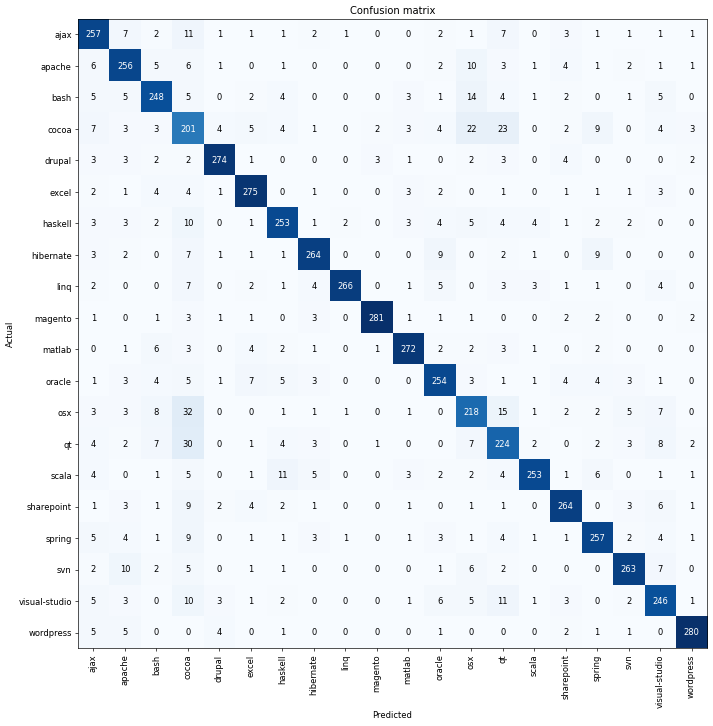

In [20]:
interpretation = ClassificationInterpretation.from_learner(learner)
interpretation.plot_confusion_matrix( figsize = (12, 12), dpi = 60)

In [21]:
interpretation.most_confused()

[('osx', 'cocoa', 32),
 ('qt', 'cocoa', 30),
 ('cocoa', 'qt', 23),
 ('cocoa', 'osx', 22),
 ('osx', 'qt', 15),
 ('bash', 'osx', 14),
 ('ajax', 'cocoa', 11),
 ('scala', 'haskell', 11),
 ('visual-studio', 'qt', 11),
 ('apache', 'osx', 10),
 ('haskell', 'cocoa', 10),
 ('svn', 'apache', 10),
 ('visual-studio', 'cocoa', 10),
 ('cocoa', 'spring', 9),
 ('hibernate', 'oracle', 9),
 ('hibernate', 'spring', 9),
 ('sharepoint', 'cocoa', 9),
 ('spring', 'cocoa', 9),
 ('osx', 'bash', 8),
 ('qt', 'visual-studio', 8),
 ('ajax', 'apache', 7),
 ('ajax', 'qt', 7),
 ('cocoa', 'ajax', 7),
 ('hibernate', 'cocoa', 7),
 ('linq', 'cocoa', 7),
 ('oracle', 'excel', 7),
 ('osx', 'visual-studio', 7),
 ('qt', 'bash', 7),
 ('qt', 'osx', 7),
 ('svn', 'visual-studio', 7),
 ('apache', 'ajax', 6),
 ('apache', 'cocoa', 6),
 ('matlab', 'bash', 6),
 ('scala', 'spring', 6),
 ('sharepoint', 'visual-studio', 6),
 ('svn', 'osx', 6),
 ('visual-studio', 'oracle', 6),
 ('apache', 'bash', 5),
 ('bash', 'ajax', 5),
 ('bash', 'apach

## 6. Predictions

Now that we've prepped and fine-tuned our model by unfreezing the layers and increasing the model's accuracy to 85.4 percent, I believe we're ready to forecast the values. It will be preserved on the hard disk so that it can be used again later.

In [22]:
content = 'Best Subversion clients for Windows Vista (64bit)'
prediction, prediction_possibility, prediction_possibilities = learner.predict(content)
print( f"prediction = {prediction}\n" )

prediction = svn



## 7. Export the model

In [23]:
# To Export the Model to the designated Drive Location
model_path = os.path.join('gdrive/My Drive/EAI 6010 Assignments Data Set/Class 3 - ULMfit/text_classifier')
learner.export(model_path)

With the following code, we've saved our final model to the drive as **text_classifier**, which can be used to do text classification and retrieve the prediction at any time in the future.